In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.metrics import log_loss,f1_score,roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import cross_validate,KFold,train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from prettytable import PrettyTable
import sklearn.svm as svm

import time
import optuna

import warnings 
warnings.filterwarnings("ignore")

# loading data

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv',index_col = "id")

df_train.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0


In [3]:
df_train.info()
# glad to see all non-null

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [4]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv',index_col = "id")

df_test.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
165039,15672704,Pearson,593,France,Female,22.0,9,0.00,2,0.0,0.0,51907.72
165040,15647838,Onyemere,682,Spain,Male,45.0,4,0.00,2,1.0,1.0,157878.67
165041,15775307,Hargreaves,539,Spain,Female,47.0,8,0.00,2,1.0,1.0,126784.29
165042,15653937,Hsueh,845,France,Female,47.0,3,111096.91,1,1.0,0.0,94978.10


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110023 entries, 165034 to 275056
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       110023 non-null  int64  
 1   Surname          110023 non-null  object 
 2   CreditScore      110023 non-null  int64  
 3   Geography        110023 non-null  object 
 4   Gender           110023 non-null  object 
 5   Age              110023 non-null  float64
 6   Tenure           110023 non-null  int64  
 7   Balance          110023 non-null  float64
 8   NumOfProducts    110023 non-null  int64  
 9   HasCrCard        110023 non-null  float64
 10  IsActiveMember   110023 non-null  float64
 11  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(4), object(3)
memory usage: 10.9+ MB


# Vertify the relation between test set and train set.
It is reasonable that it is more acurate if the test and train set both sampled from one population.

In [6]:
# To see whether the test and train set are both from a same or similar population
def compair_train_and_test(name):
    sns.kdeplot(df_train[name],legend = "train");
    sns.kdeplot(df_test[name],legend = "test");

In [7]:
df_test.columns.values

array(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'], dtype=object)

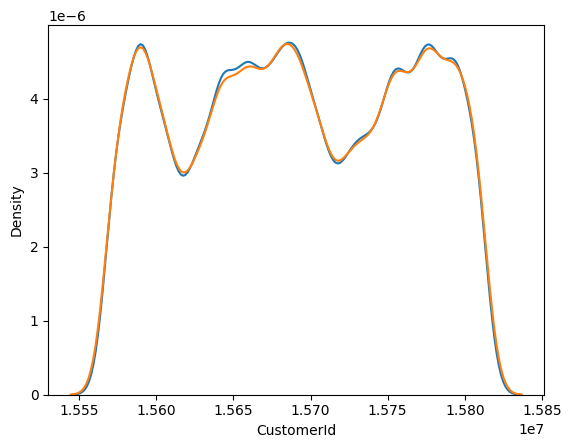

In [8]:
compair_train_and_test("CustomerId")

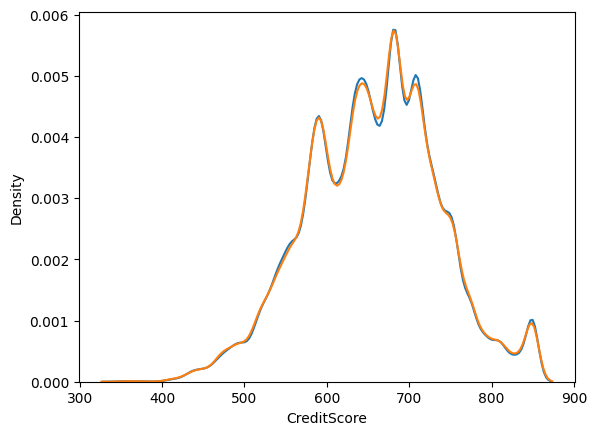

In [9]:
compair_train_and_test("CreditScore")

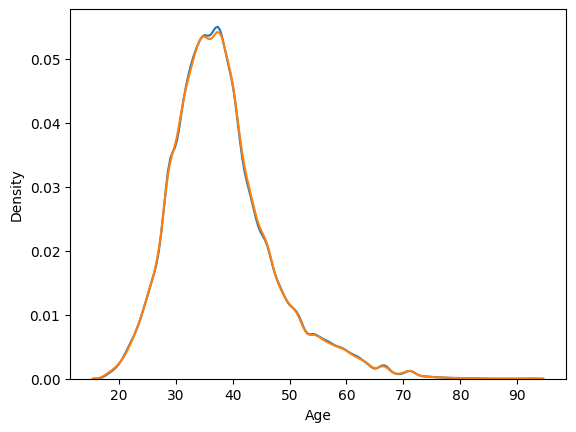

In [10]:
compair_train_and_test("Age")

# EDA

In [11]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,15633141.00,15690169.0,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,597.00,659.0,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,32.00,37.0,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.00,5.0,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.00,0.0,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.00,2.0,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.00,1.0,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.00,0.0,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,74637.57,117948.0,1.551525e+05,199992.48
Exited,165034.0,2.115988e-01,0.408443,0.00,0.00,0.0,0.000000e+00,1.00


In [12]:
#Dividing all the features into categories
cat_cols = ['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember']
numeric_cols = ['CustomerId','CreditScore','Age','Balance','EstimatedSalary']
#Surname is just ignored

## Categorical

### Overview

In [13]:
def Categorical(df,cat_cols,n_cols=3):
    number_cols = len(df[cat_cols].columns)
    if(number_cols % n_cols == 0):
        n_rows=int(number_cols/n_cols)
    else:
        n_rows = number_cols//n_cols +1
    fig,axes = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(4*n_cols,4*n_rows))
    axes= axes.flatten()
      
    for i, col in enumerate(cat_cols):
        values = df[col].value_counts()
        axes[i].pie(values,labels=values.index,autopct="%0.1f%%",shadow=True,textprops={'size':15,'color':'black'},
                    explode = [0.05] * len(df[col].unique()))
        axes[i].set_aspect = 'equal'
        axes[i].set_title(f'Distribution of {col}')
        
    plt.tight_layout()
    plt.show()

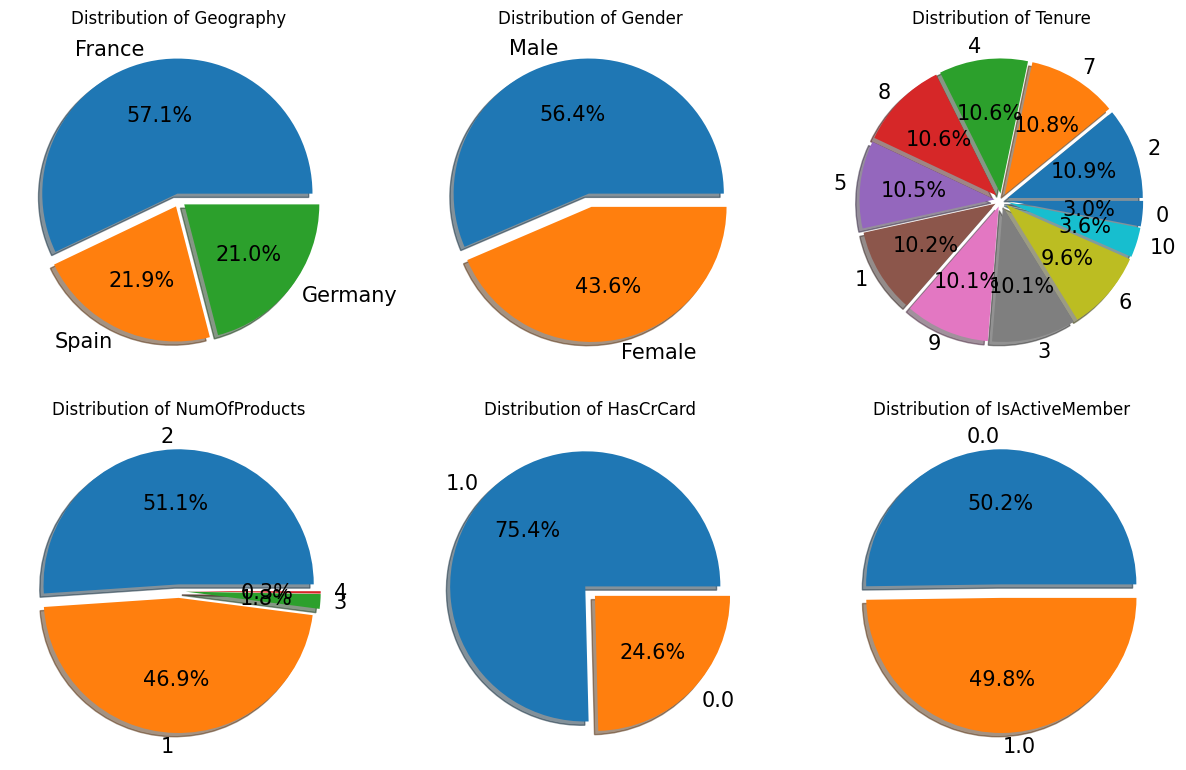

In [14]:
Categorical(df_train,cat_cols)

### For each colum

In [15]:
#show relations of each feasure and Exited
def eda_plots(df, name, Exited):
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 4)
    sns.barplot(x = df[Exited], y = name, data = df)   
    plt.title('Barplot')
    
    #histplot
    plt.subplot(1, 4, 1)
    skew = df[name].skew()
    sns.histplot(df[name], kde = True, stat="density", 
                 label='Skew = %.3f' %(skew), bins=30, color = 'r')
    plt.legend(loc='best')
    plt.title('Histogram')

    #scatter
    plt.subplot(1, 4, 2)
    plt.scatter(x=df[name], y=df[Exited], color = 'g')
    plt.title('Scatterplot')
    
    #violinplot
    plt.subplot(1, 4, 3)
    sns.violinplot(y=df[name], color = 'b', x= df['Exited'])
    plt.title('Boxplot')

    plt.show()

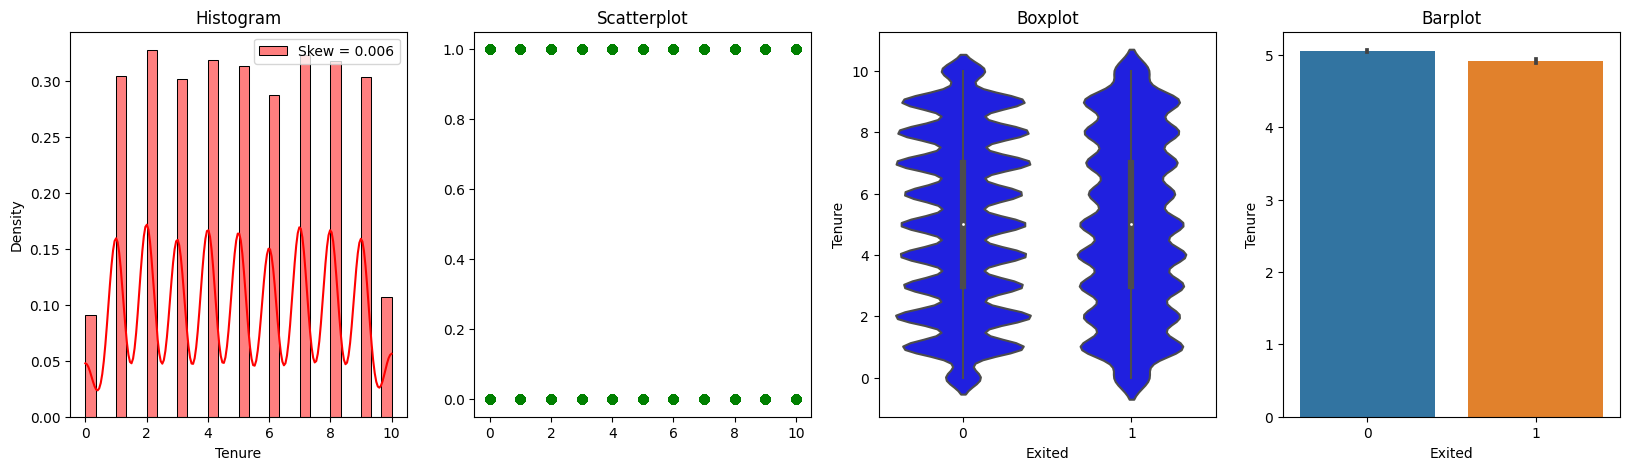

In [16]:
eda_plots(df_train,"Tenure", "Exited")

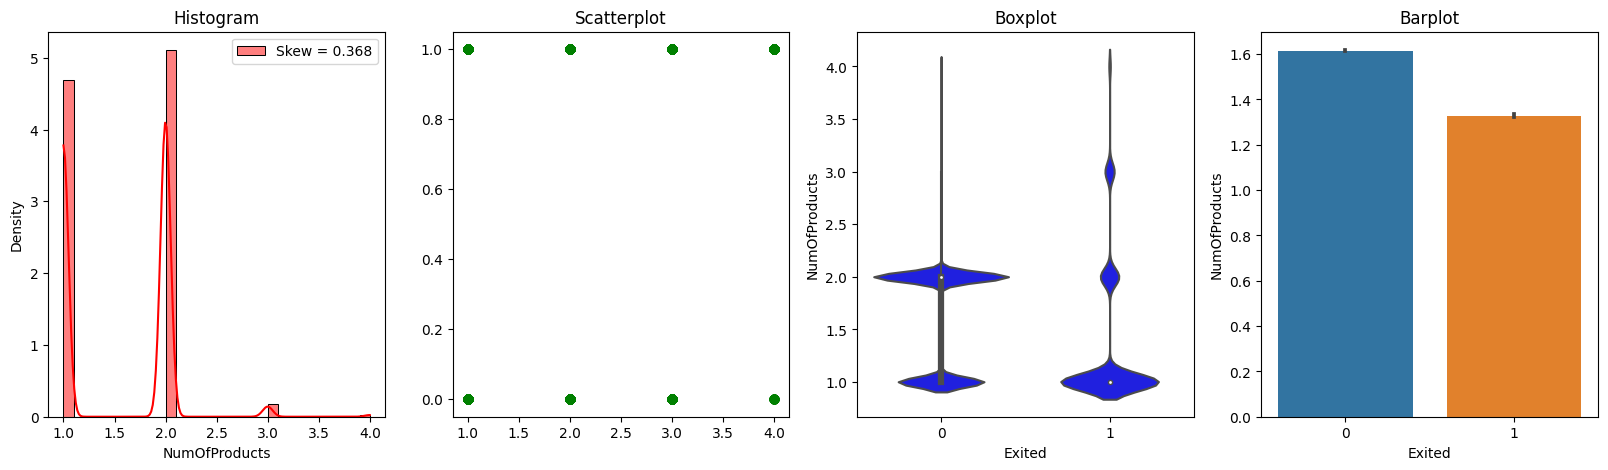

In [17]:
eda_plots(df_train,"NumOfProducts", "Exited")

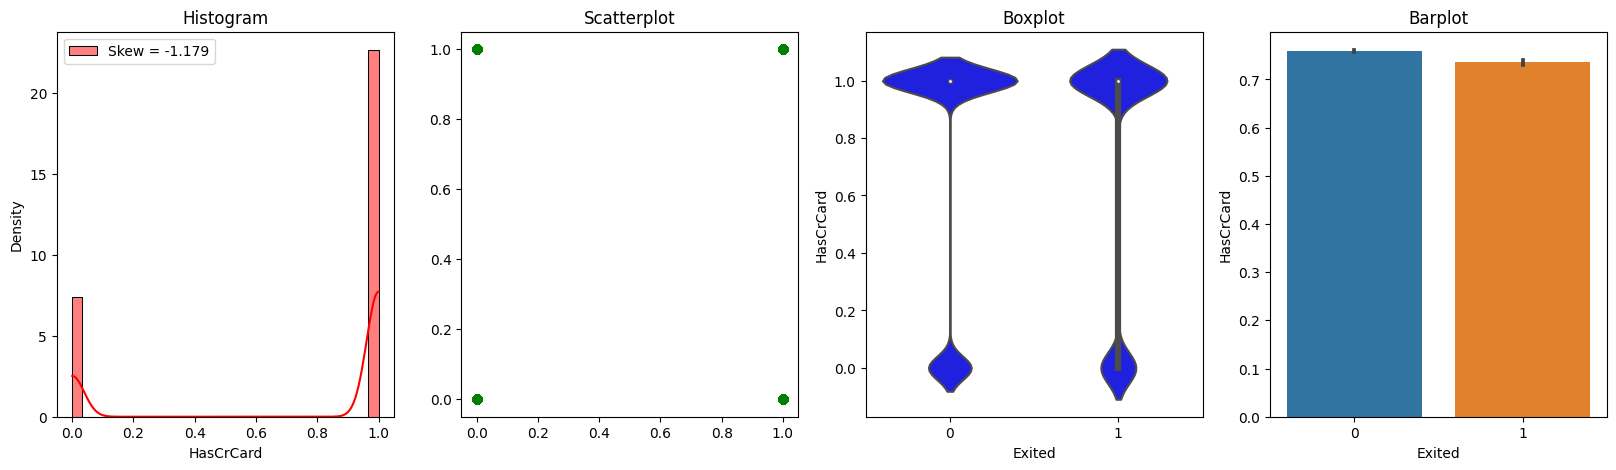

In [18]:
eda_plots(df_train,"HasCrCard", "Exited")

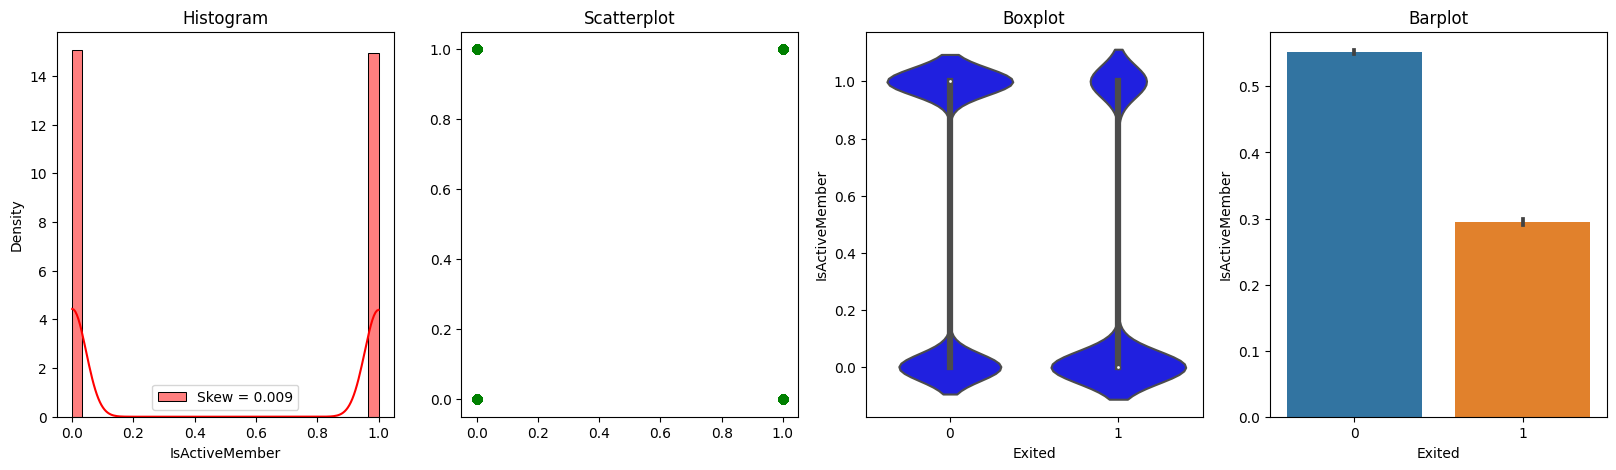

In [19]:
eda_plots(df_train,"IsActiveMember", "Exited")

## Continuious

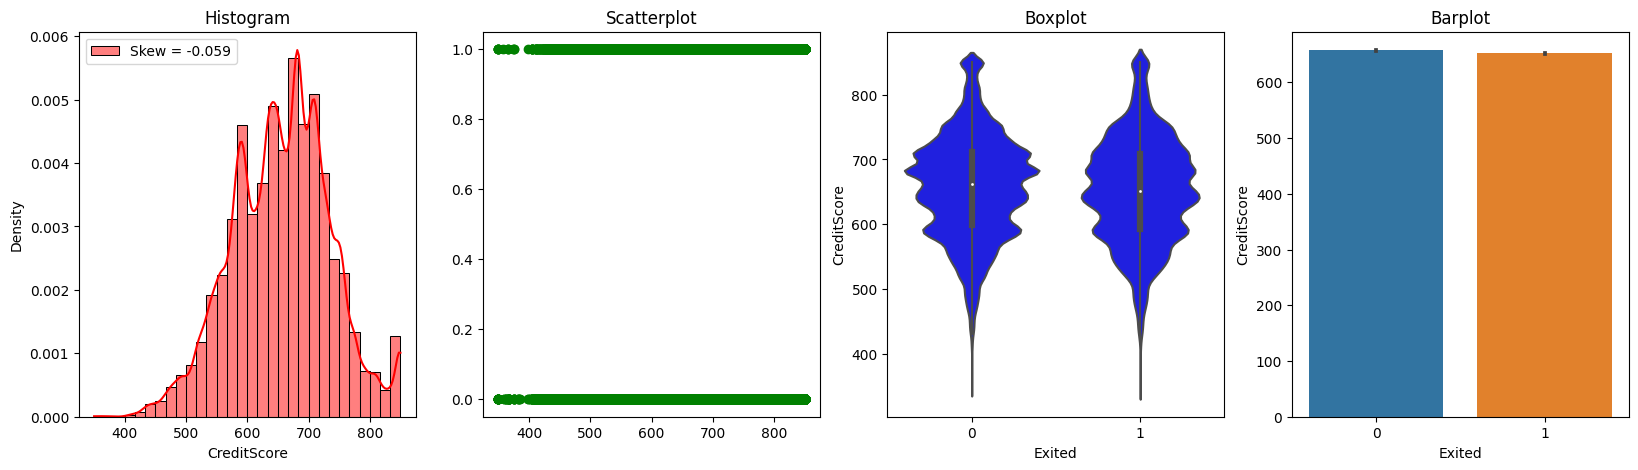

In [20]:
eda_plots(df_train,"CreditScore", "Exited")

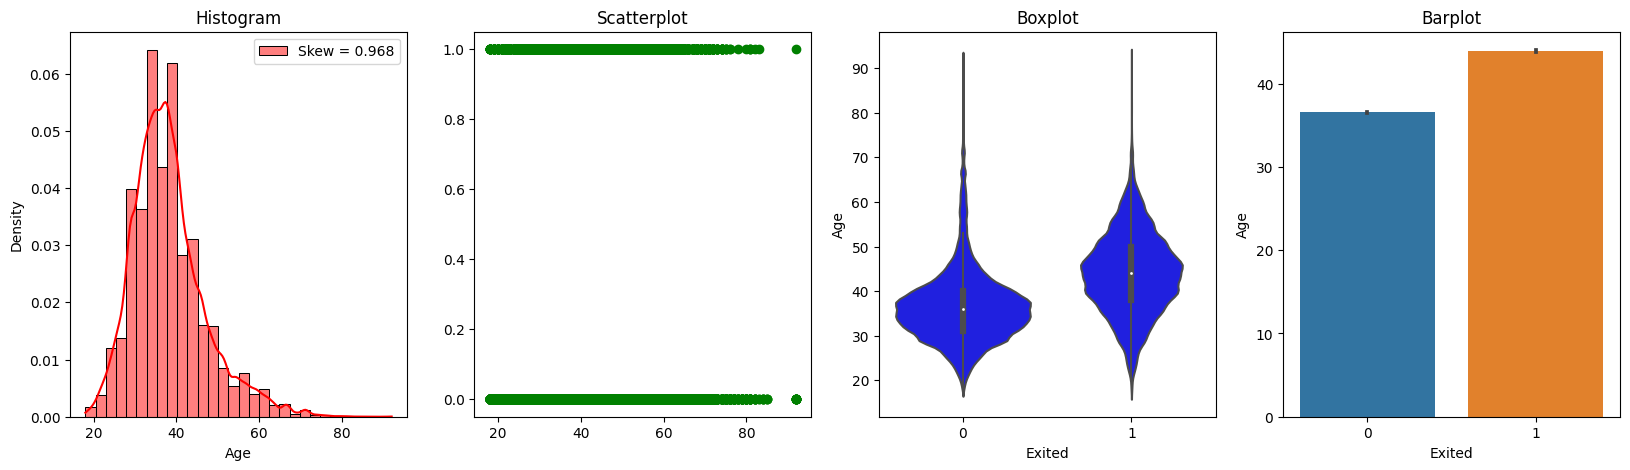

In [21]:
eda_plots(df_train,"Age", "Exited")

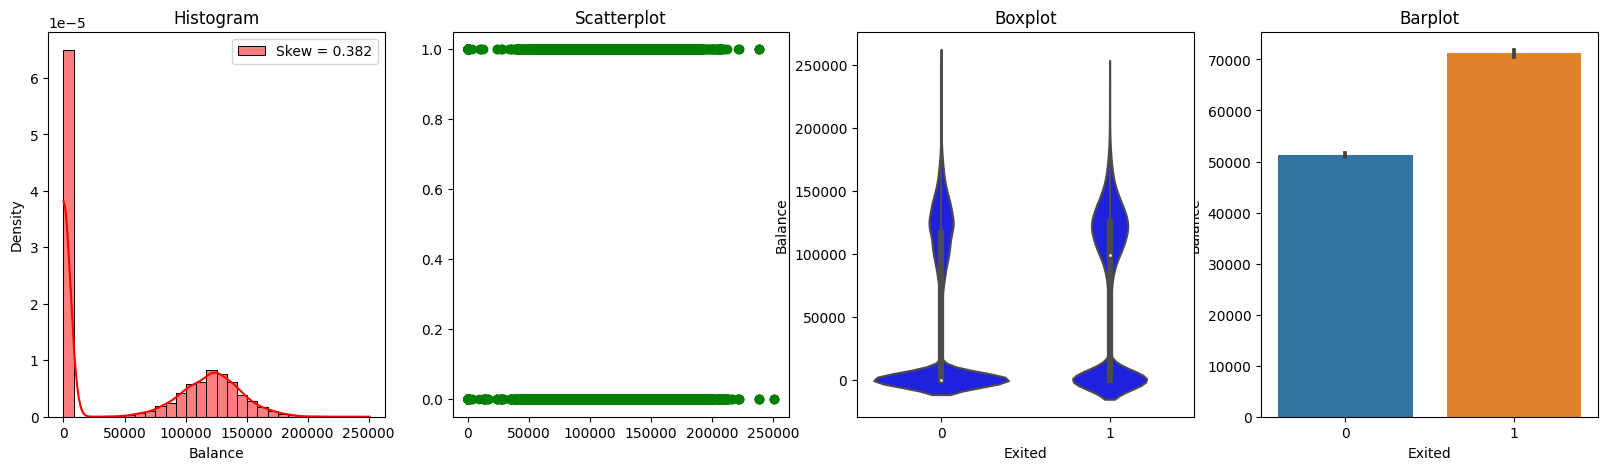

In [22]:
eda_plots(df_train,"Balance", "Exited")

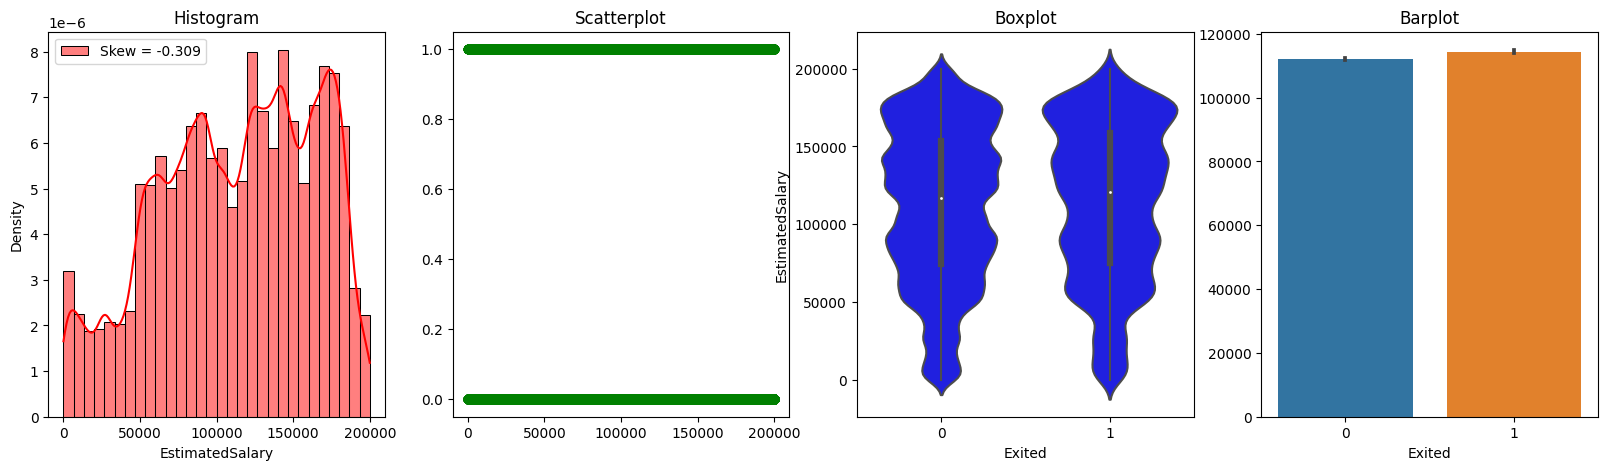

In [23]:
eda_plots(df_train, 'EstimatedSalary', 'Exited')

# Feature Engineering

In [24]:
age_mean,age_std = df_train["Age"].mean(),df_train["Age"].std()
age_mean,age_std

(38.12588787764945, 8.867204591410783)

In [25]:
#Adding a risk factor. Males and people from Germany have a higher chance to churn 
df_train['Risk'] = np.where((df_train['Age'] > (age_mean - age_std)) & (df_train['Age'] < (age_mean - age_std)) & (df_train['Geography'] == "Germany") & (df_train['Gender'] == 1), 1,0)
df_test['Risk'] = np.where((df_test['Age'] > (age_mean - age_std)) & (df_test['Age'] < (age_mean - age_std)) & (df_test['Geography'] == "Germany") & (df_test['Gender'] == 1), 1,0)
cat_cols.append("Risk")

In [26]:
#Based on balance EDA, people with zero balance are less likely to churn and people with balance 100k - 150k have higher chance to churn 
df_train['ZeroBalance'] = df_train['Balance'].apply(lambda x : 1 if x == 0 else 0)
df_test['ZeroBalance'] = df_test['Balance'].apply(lambda x : 1 if x == 0 else 0)

df_train['Balance(100-150k)'] = df_train['Balance'].apply(lambda x : 1 if x >= 10000 and x<=150000 else 0)
df_test['Balance(100-150k)'] = df_test['Balance'].apply(lambda x : 1 if x >= 10000 and x<=150000 else 0)

In [27]:
transformer_num = make_pipeline(
    # SimpleImputer(strategy="constant"), #no null value
    StandardScaler(),
)
transformer_cat = make_pipeline(
    #SimpleImputer(strategy="constant", fill_value="NA"), #no null value
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, numeric_cols),
    (transformer_cat, cat_cols),
)

In [28]:
X = df_train.copy()
y = X.pop("Exited")

X_test = df_test.copy()

In [29]:
# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

X_test_transformed = preprocessor.transform(X_test)

# Modeling

In [30]:
def score_of_the_model(model):
    s1 = model.score(X_train,y_train)
    s2 = model.score(X_valid,y_valid)
    print('training set',s1)
    print('testing set',s2)

In [31]:
#Making a cross validation
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [32]:
def CrossValidate(clf,X,y):
    X = X
    y = y.to_numpy()
    scores = PrettyTable()
    scores.field_names = ['Fold','Accuracy','Roc_auc','Confusion Matrix','time to train']
    conf_matrices = []
    accuracies = []
    roc_auc_scores = []
    training_times = []
    for  train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        start = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]
        conf_matrices.append(confusion_matrix(y_test, y_pred))
        accuracies.append(round(accuracy_score(y_test, y_pred),5))
        roc_auc_scores.append(round(roc_auc_score(y_test, y_prob),5))
        end = time.time()
        training_times.append(round(end-start,2))

    for i in range(5):
        scores.add_row([(i+1),accuracies[i],roc_auc_scores[i],conf_matrices[i],training_times[i]])

    print(scores)
    print(f"Mean accuracy - {sum(accuracies) / 5}")
    print(f"Mean roc_auc - {sum(roc_auc_scores) / 5}") 

## LGB

lgbm_best_params = {'num_leaves': 52,
 'learning_rate': 0.07895324521843525,
 'feature_fraction': 0.5658166490064884,
 'bagging_fraction': 0.4307596104050439,
 'reg_alpha': 0.0740870606923929,
 'reg_lambda': 2.6993567325444864e-06,
 'min_child_samples': 10,
                   'verbose':-1}

In [33]:
#Using optuna we got these hyper parameters
lgbm_best_params = {'num_leaves': 50,
 'learning_rate': 0.08,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.4,
 'reg_alpha': 0.07,
 'reg_lambda': 2e-06,
 'min_child_samples': 10,
                   'verbose':-1}

In [34]:
lgbm = LGBMClassifier(**lgbm_best_params)

In [35]:
CrossValidate(lgbm,X_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fractio

In [36]:
score_of_the_model(lgbm)

training set 0.8717269238537669
testing set 0.8639569548462154


## Random forest

In [37]:
rfc = RandomForestClassifier(
    n_estimators=40, criterion="gini", max_depth=14,  
    min_samples_split=2, min_samples_leaf=1,  
    min_weight_fraction_leaf=0.0,  
    max_features="auto",  
    max_leaf_nodes=None, bootstrap=True,  
    oob_score=False, n_jobs=1, random_state=None, verbose=0,  
    warm_start=False, class_weight=None
)


In [38]:
CrossValidate(rfc,X_train,y_train)

+------+----------+---------+------------------+---------------+
| Fold | Accuracy | Roc_auc | Confusion Matrix | time to train |
+------+----------+---------+------------------+---------------+
|  1   | 0.86156  | 0.88441 |  [[18610   907]  |      6.19     |
|      |          |         |  [ 2520  2718]]  |               |
|  2   | 0.86249  | 0.88667 |  [[18584   933]  |      5.84     |
|      |          |         |  [ 2471  2767]]  |               |
|  3   | 0.86407  | 0.88476 |  [[18577   940]  |      5.95     |
|      |          |         |  [ 2425  2813]]  |               |
|  4   | 0.86508  | 0.88559 |  [[18621   896]  |      5.8      |
|      |          |         |  [ 2444  2794]]  |               |
|  5   | 0.86282  | 0.88693 |  [[18607   909]  |      5.79     |
|      |          |         |  [ 2487  2752]]  |               |
+------+----------+---------+------------------+---------------+
Mean accuracy - 0.863204
Mean roc_auc - 0.8856719999999999


In [39]:
score_of_the_model(rfc)

training set 0.8893718440719046
testing set 0.8618483240020359


## XGBoost

In [40]:
#Parameters obtained from optuna
xg_best_params = {'lambda': 0.40093945695899574,
 'alpha': 0.003367228970383607,
 'subsample': 0.9015674829231023,
 'colsample_bytree': 0.432988538034984,
 'learning_rate': 0.04678656681603368,
 'n_estimators': 478,
 'max_depth': 6,
 'min_child_weight': 6,
 'gamma': 0.00021168183130911497}

In [41]:
xg = XGBClassifier(**xg_best_params)

In [42]:
CrossValidate(xg,X_train,y_train)

+------+----------+---------+------------------+---------------+
| Fold | Accuracy | Roc_auc | Confusion Matrix | time to train |
+------+----------+---------+------------------+---------------+
|  1   | 0.86544  |  0.8884 |  [[18499  1018]  |     16.19     |
|      |          |         |  [ 2313  2925]]  |               |
|  2   |  0.8658  | 0.89094 |  [[18492  1025]  |     15.95     |
|      |          |         |  [ 2297  2941]]  |               |
|  3   | 0.86706  | 0.88934 |  [[18544   973]  |     16.05     |
|      |          |         |  [ 2318  2920]]  |               |
|  4   | 0.86665  | 0.88982 |  [[18535   982]  |     16.01     |
|      |          |         |  [ 2319  2919]]  |               |
|  5   | 0.86621  | 0.89143 |  [[18548   968]  |     15.97     |
|      |          |         |  [ 2344  2895]]  |               |
+------+----------+---------+------------------+---------------+
Mean accuracy - 0.8662319999999999
Mean roc_auc - 0.889986


## Cat Boost

In [43]:
cat = CatBoostClassifier(verbose=0)

In [44]:
CrossValidate(cat,X_train,y_train)

+------+----------+---------+------------------+---------------+
| Fold | Accuracy | Roc_auc | Confusion Matrix | time to train |
+------+----------+---------+------------------+---------------+
|  1   |  0.8635  | 0.88687 |  [[18510  1007]  |     15.61     |
|      |          |         |  [ 2372  2866]]  |               |
|  2   | 0.86492  | 0.88885 |  [[18489  1028]  |     15.45     |
|      |          |         |  [ 2316  2922]]  |               |
|  3   | 0.86714  | 0.88851 |  [[18567   950]  |     15.49     |
|      |          |         |  [ 2339  2899]]  |               |
|  4   |  0.8656  |  0.8883 |  [[18544   973]  |     15.56     |
|      |          |         |  [ 2354  2884]]  |               |
|  5   | 0.86641  | 0.89029 |  [[18566   950]  |     15.63     |
|      |          |         |  [ 2357  2882]]  |               |
+------+----------+---------+------------------+---------------+
Mean accuracy - 0.8655139999999999
Mean roc_auc - 0.888564


# Output

In [45]:
voting = VotingClassifier(estimators=[('lgbm',lgbm),('rfc',rfc),('xg',xg),('cat',cat)],voting='soft',weights=[1,1,2,1])

In [46]:
CrossValidate(voting,X_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fractio

In [47]:
voting.fit(X_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4


VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(bagging_fraction=0.4,
                                             feature_fraction=0.6,
                                             learning_rate=0.08,
                                             min_child_samples=10,
                                             num_leaves=50, reg_alpha=0.07,
                                             reg_lambda=2e-06, verbose=-1)),
                             ('rfc',
                              RandomForestClassifier(max_depth=14,
                                                     max_features='auto',
                                                     n_estimators=40,
                                                     n_jobs=1)),
                             ('xg',
                              XGBClassifier(alpha=0.003367228970383607,
                                            base_score=None, boos...
                                            learning_rate=0.04678656681603368,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=6,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=478, n_jobs=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x782dc0ce1a80>)],
                 voting='soft', weights=[1, 1, 2, 1])

In [48]:
predictions = voting.predict(X_test_transformed)

df_test["Exited"] = predictions

output = df_test["Exited"].reset_index()
output.to_csv("output_muti_model.csv",index=False,sep=',')